In [ ]:
%pip install numpy
%pip install matplotlib

In [293]:
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Tuple, Union, Optional, Generator
from math import ceil, floor, sqrt

## Setup

### Helper functions

In [1152]:
def split_data(points: np.ndarray, labels: np.ndarray, train_size: Union[int, float], test_size: Union[int, float]):
    """Split data into train and test datasets
    """
    number_of_points = points.shape[0]

    if isinstance(train_size, float) and isinstance(test_size, float):
        if (train_size + test_size) != 1.0:
            raise ValueError(f"train size + test size should be equal to 1.0")

        train_size = ceil(train_size * number_of_points)
        test_size = floor(test_size * number_of_points)
    elif isinstance(train_size, int) and isinstance(test_size, int):
        if number_of_points != (train_size + test_size):
            raise ValueError(f"train size + test size should be equal to the number of points")
    else:
        raise TypeError("train_size and test_size should be the same type")

    splitted_points = np.split(points, [train_size, number_of_points], axis=0)[:-1]
    splitted_labels = np.split(labels, [train_size, number_of_points], axis=0)[:-1]
    return splitted_points + splitted_labels

### Data generator

In [568]:
class Data:
    _DATA_RANDOM_SEED: int = 8765
    _data_random_generator: np.random.Generator = np.random.default_rng(seed=5678)

    # deterministic random generator for data
    @classmethod
    def get_data_random_generator(cls, deterministic: bool = True) -> np.random.Generator:
        if deterministic:
            return np.random.default_rng(seed=cls._DATA_RANDOM_SEED)
        else:
            return cls._data_random_generator

    @classmethod
    def generate_uniform_data(cls, n: int):
        points = cls.get_data_random_generator().uniform(low=0.0, high=1.0, size=(n, 2))
        labels = np.fromiter(map(lambda point: int(point[0] <= point[1]), points), dtype=int)
        return points, np.expand_dims(labels, axis=-1)

    @classmethod
    def generate_X_like_data(cls):
        points = []
        labels = []
        for i in range(11):
            value = 0.1 * i
            points.append([value, value])
            labels.append(0)

            if value == 0.5:
                continue

            points.append([value, 1 - value])
            labels.append(1)
        return np.array(points, dtype=float), np.expand_dims(np.array(labels, dtype=int), axis=-1)

### Optimizers

In [328]:
class Optimizer:
    def reset(self) -> None:
        pass

    def step(self, parameter: np.ndarray, gradient: np.ndarray) -> None:
        pass

class SGD(Optimizer):
    _learning_rate: float

    def __init__(self, learning_rate: float):
        self._learning_rate = learning_rate

    def step(self, parameter: np.ndarray, gradient: np.ndarray) -> None:
        parameter += -self._learning_rate * gradient

class Momentum(Optimizer):
    _learning_rate: float
    _momentum: float

    _velocity: List[np.ndarray]
    _current_velocity_index: int

    def __init__(self, learning_rate: float, momentum: float = 0.9) -> None:
        self._learning_rate = learning_rate
        self._momentum = momentum
        self._velocity = []
        self.reset()

    def reset(self) -> None:
        self._current_velocity_index = 0

    def step(self, parameter: np.ndarray, gradient: np.ndarray) -> None:
        if len(self._velocity) == self._current_velocity_index:
            self._velocity.append(np.zeros_like(gradient))

        velocity = self._velocity[self._current_velocity_index]
        velocity = self._momentum * velocity - self._learning_rate * gradient
        self._velocity[self._current_velocity_index] = velocity
        self._current_velocity_index += 1

        parameter += velocity

### Loss

In [924]:
def calculate_MSE_loss(y_pred: np.ndarray, y_true: np.ndarray):
    loss = np.mean((y_true - y_pred) ** 2.0)
    gradient = np.mean(-2.0 * (y_true - y_pred))
    return loss, gradient

def calculate_NLL_loss(y_pred: np.ndarray, y_true: np.ndarray):
    # epsilon = 1e-10
    # y_pred += epsilon
    # sign = 1 - 2 * y_true
    # exp_pred = np.exp(sign * y_pred)
    # x = 1 + exp_pred

    # loss = np.mean(np.log(x))
    # gradient = np.mean(sign * exp_pred / x)
    loss = -np.mean((y_true * np.log(y_pred)) + ((1.0 - y_true) * np.log(1.0 - y_pred)))
    gradient = -np.mean((y_true * 1.0 / y_pred) - ((1.0 - y_true) * 1.0 / (1.0 - y_pred)))
    return loss, gradient

### Network components

In [1144]:
class Module:
    def reset_parameters(self) -> None:
        pass

    def forward(self, x: np.ndarray) -> np.ndarray:
        return None

    def backward(self, g: np.ndarray) -> np.ndarray:
        return None

    def update(self, optimizer: Optimizer) -> None:
        pass

    def weight(self) -> np.ndarray:
        return None

    def bias(self) -> np.ndarray:
        return None

class Sigmoid(Module):
    _input: np.ndarray

    def __init__(self) -> None:
        super(Sigmoid, self).__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self._input = x
        return 1.0 / (1.0 + np.exp(-x))

    def backward(self, g: np.ndarray) -> np.ndarray:
        return g * self._input * (1.0 - self._input)

    def __str__(self) -> str:
        return f"shape of activation: *"

class Relu(Module):
    _input: np.ndarray

    def __init__(self) -> None:
        super(Relu, self).__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self._input = x
        return np.maximum(0.0, x)

    def backward(self, g: np.ndarray) -> np.ndarray:
        tmp = np.maximum(0.0, self._input)
        tmp[tmp > 0] = 1.0
        return g * tmp

    def __str__(self) -> str:
        return f"shape of activation: *"

class LeakyRelu(Module):
    _input: np.ndarray
    _a: float

    def __init__(self, a: float) -> None:
        super(LeakyRelu, self).__init__()
        self._a = a

    def forward(self, x: np.ndarray) -> np.ndarray:
        self._input = x.copy()
        x[x < 0] *= self._a
        return x

    def backward(self, g: np.ndarray) -> np.ndarray:
        tmp = self._input.copy()
        tmp[tmp >= 0] = 1.0
        tmp[tmp < 0] = self._a
        return g * tmp

    def __str__(self) -> str:
        return f"shape of activation: *"

class Dense(Module):
    _random_generator: np.random.Generator
    _input_feature_size: int
    _output_feature_size: int
    _weight: np.ndarray
    _gradient_weight: np.ndarray
    _bias: np.ndarray
    _gradient_bias: np.ndarray

    _input: np.ndarray

    def __init__(self, input_feature_size: int, output_feature_size: int, bias: bool = True, random_generator: np.random.Generator = np.random.default_rng()) -> None:
        super(Dense, self).__init__()
        self._random_generator = random_generator
        self._input_feature_size = input_feature_size
        self._output_feature_size = output_feature_size
        self._weight = np.zeros((output_feature_size, input_feature_size))
        if bias:
            self._bias = np.zeros(output_feature_size)
        else:
            self._bias = None

    def reset_parameters(self) -> None:
        random_range = sqrt(1 / self._input_feature_size)
        self._weight = self._random_generator.uniform(low = -random_range, high = random_range, size = self._weight.shape)
        if self._bias is not None:
            self._bias = self._random_generator.uniform(low = -random_range, high = random_range, size = self._bias.shape)

    def forward(self, x: np.ndarray) -> np.ndarray:
        # x = * x input_feature_size, self._weight = output_feature_size x input_feature_size
        self._input = x
        # @ is equivalent to np.matmul, + is equivalent to np.add
        y = x @ self._weight.swapaxes(-1, -2)
        if self._bias is not None:
            y += self._bias
        return y

    def backward(self, g: np.ndarray) -> np.ndarray:
        self._gradient_weight = g.swapaxes(-1, -2) @ self._input
        if self._bias is not None:
            self._gradient_bias = g.mean(axis = 0)
        return g @ self._weight

    def update(self, optimizer: Optimizer) -> None:
        optimizer.step(self._weight, self._gradient_weight)
        if self._bias is not None:
            optimizer.step(self._bias, self._gradient_bias)

    def weight(self) -> np.ndarray:
        return self._weight

    def bias(self) -> np.ndarray:
        return self._bias

    def __str__(self) -> str:
        return f"shape of weights: {self._weight.shape}\n" \
            + f"shape of bias: {self._bias.shape}"

class UniformNetwork:
    _layers: List[Module]
    _activation: Module

    _logits: np.ndarray

    def __init__(self, input_size: int, output_size: int, hidden_units: Union[List, Tuple], random_generator: np.random.Generator, bias: bool = True) -> None:
        super(UniformNetwork, self).__init__()
        self._layers = []

        for hidden_unit in hidden_units:
            hidden_size = hidden_unit[0]
            bias = hidden_unit[1]
            layer = Dense(input_size, hidden_size, bias = bias, random_generator = random_generator)
            self._layers.extend([layer, Sigmoid()])
            input_size = hidden_size

        output_layer = Dense(input_size, output_size, bias = bias, random_generator = random_generator)
        self._layers.extend([output_layer])

        self._activation = Sigmoid()

        for layer in self._layers:
            layer.reset_parameters()

    def predict(self, x: np.ndarray) -> np.ndarray:
        y = x
        for layer in self._layers:
            y = layer.forward(y)
        self._logits = y
        y = self._activation.forward(y)
        return y

    def backward(self, g: np.ndarray) -> np.ndarray:
        g = self._activation.backward(g)
        for i in range(len(self._layers) - 1, -1, -1):
            g = self._layers[i].backward(g)
        return None

    def update(self, optimizer: Optimizer) -> None:
        for layer in self._layers:
            layer.update(optimizer)

    def list_network(self) -> None:
        print("=" * 50)
        for layer in self._layers:
            print(layer)
            print("-" * 50)
        print("=" * 50)

    def weights(self) -> Generator:
        for layer in self._layers:
            yield layer.weight()

    def logits(self) -> np.ndarray:
        return self._logits

class XORNetwork:
    _layers: List[Module]
    _activation: Module

    _logits: np.ndarray

    def __init__(self, input_size: int, output_size: int, hidden_units: Union[List, Tuple], random_generator: np.random.Generator, bias: bool = True) -> None:
        super(XORNetwork, self).__init__()
        self._layers = []

        for hidden_unit in hidden_units:
            hidden_size = hidden_unit[0]
            bias = hidden_unit[1]
            a = hidden_unit[2]
            layer = Dense(input_size, hidden_size, bias = bias, random_generator = random_generator)
            self._layers.extend([layer, LeakyRelu(a)])
            input_size = hidden_size

        output_layer = Dense(input_size, output_size, bias = bias, random_generator = random_generator)
        self._layers.extend([output_layer])

        self._activation = Sigmoid()

        for layer in self._layers:
            layer.reset_parameters()

    def predict(self, x: np.ndarray) -> np.ndarray:
        y = x
        for layer in self._layers:
            y = layer.forward(y)
        self._logits = y
        y = self._activation.forward(y)
        return y

    def backward(self, g: np.ndarray) -> np.ndarray:
        g = self._activation.backward(g)
        for i in range(len(self._layers) - 1, -1, -1):
            g = self._layers[i].backward(g)
        return None

    def update(self, optimizer: Optimizer) -> None:
        for layer in self._layers:
            layer.update(optimizer)

    def list_network(self) -> None:
        print("=" * 50)
        for layer in self._layers:
            print(layer)
            print("-" * 50)
        print("=" * 50)

    def weights(self) -> Generator:
        for layer in self._layers:
            yield layer.weight()

    def logits(self) -> np.ndarray:
        return self._logits

## Results

In [1149]:
def show_loss(train_loss: list, test_loss: list) -> None:
    epochs = list(range(1, len(train_loss) + 1))
    plt.figure()
    plt.title("Learning Curve", fontsize=14)
    plt.plot(epochs, train_loss, "ro", label = "train loss")
    plt.plot(epochs, test_loss, "bo", label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def show_accuracy(train_accuracy: list, test_accuracy: list) -> None:
    epochs = list(range(1, len(train_accuracy) + 1))
    plt.figure()
    plt.title("Train Accuracy vs Validation Accuracy", fontsize=14)
    plt.plot(epochs, train_accuracy, "ro", label = "train accuracy")
    plt.plot(epochs, test_accuracy, "bo", label = "test accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

In [1156]:
class Trainer:
    def __init__(self, model, optimizer: Optimizer, epochs: int, early_stop: bool = False, early_stopping_times: int = 2):
        self._model = model
        self._optimizer = optimizer
        self._epochs = epochs
        self._early_stop = early_stop
        self._early_stopping_times = early_stopping_times

    def _calculate_accuracy(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        return np.mean(self._normalize_result(y_pred) == y_true)

    def _shuffle_data(self, random_generator: np.random.Generator, x: np.ndarray, y: np.ndarray):
        data = list(zip(x, y))
        random_generator.shuffle(data, axis = 0)
        return list(map(np.array, zip(*data)))

    def _normalize_result(self, y: np.ndarray) -> np.ndarray:
        return np.round(y)

    def train(self, x_train, x_val, y_train, y_val):
        loss_trains = []
        loss_vals = []
        accuracy_trains = []
        accuracy_vals = []
        times = 0

        shuffle_generator = np.random.default_rng(seed = 888)
        for epoch in range(1, self._epochs + 1):
            x_train, y_train = self._shuffle_data(shuffle_generator, x_train, y_train)

            y_pred = self._model.predict(x_train)
            loss_train, g = calculate_NLL_loss(y_pred, y_train)

            self._model.backward(g)
            self._model.update(self._optimizer)
            self._optimizer.reset()

            accuracy_train = self._calculate_accuracy(y_pred, y_train)
            loss_val, accuracy_val = self.validate(x_val, y_val)

            if epoch % 1000 == 0:
                print(f"epoch: {epoch}, train loss: {loss_train}, validation loss: {loss_val}")
                # print(f"epoch: {epoch}, train accuracy: {accuracy_train}, validation accuracy: {accuracy_val}")

            loss_trains.append(loss_train)
            loss_vals.append(loss_val)
            accuracy_trains.append(accuracy_train)
            accuracy_vals.append(accuracy_val)

            diff_loss_train = loss_trains[len(loss_trains) - 2] - loss_train
            if self._early_stop and diff_loss_train <= 0:
                times += 1
                print(f"trigger early stopping: {times}")
                if times == self._early_stopping_times:
                    loss_val, _ = self.validate(x_val, y_val)
                    print(f"early stopped at epoch: {epoch}, train loss: {loss_train}, validation loss: {loss_val}")
                    break
            else:
                times = 0
        return loss_trains, loss_vals, accuracy_trains, accuracy_vals

    def validate(self, x: np.ndarray, y: np.ndarray):
        y_pred = self._model.predict(x)
        loss, _ = calculate_NLL_loss(y_pred, y)
        accuracy = self._calculate_accuracy(y_pred, y)
        return loss, accuracy

    def test(self, x: np.ndarray, y: np.ndarray):
        y_pred = self._model.predict(x)
        print("Test Predict Result:")
        print(y_pred)
        accuracy = self._calculate_accuracy(y_pred, y)
        print("Test Predict Accuracy:", accuracy)

        y_pred = self._normalize_result(y_pred)

        plt.subplot(1, 2, 1)
        plt.title("Ground Truth", fontsize=14)
        for i in range(x.shape[0]):
            point = x[i]
            color = "bo" if y[i] == 1 else "ro"
            plt.plot(point[0], point[1], color)

        plt.subplot(1, 2, 2)
        plt.title("Test Predict Result", fontsize=14)
        for i in range(x.shape[0]):
            point = x[i]
            color = "bo" if y_pred[i] == 1 else "ro"
            plt.plot(point[0], point[1], color)
        plt.show()

### Uniform distribution

* 10000 筆  
  lr = 1e-5
* 20000 筆  
  lr = 3e-5

In [1122]:
def get_uniform_data():
    points, labels = Data.generate_uniform_data(10000)
    x_train, x_val, y_train, y_val = split_data(points, labels, 0.8, 0.2)
    x_test, y_test = Data.generate_uniform_data(300)

    print("shape of train data:", x_train.shape)
    print("shape of validation data:", x_val.shape)
    print("shape of test data:", x_test.shape)

    print("number of 1 in train data:", np.sum(y_train == 1))
    print("number of 0 in train data:", np.sum(y_train == 0))
    print("number of 1 in validation data:", np.sum(y_val == 1))
    print("number of 0 in validation data:", np.sum(y_val == 0))

    return x_train, x_val, x_test, y_train, y_val, y_test

shape of train data: (8000, 2)
shape of validation data: (2000, 2)
shape of test data: (300, 2)
number of 1 in train data: 3987
number of 0 in train data: 4013
number of 1 in validation data: 983
number of 0 in validation data: 1017
trigger early stopping: 1
trigger early stopping: 1
trigger early stopping: 2
early stopped at epoch: 560, train loss: 0.689691645927949, validation loss: 0.6897011405500441


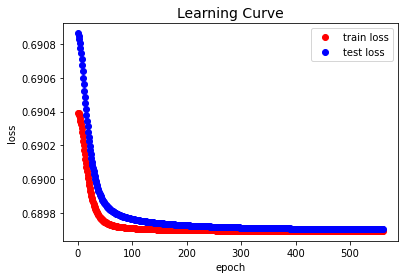

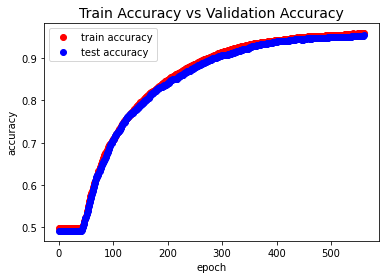

Test Predict Result:
[[0.50278168]
 [0.49857396]
 [0.50165231]
 [0.50360384]
 [0.50006781]
 [0.49886219]
 [0.50095606]
 [0.50176168]
 [0.49659543]
 [0.49876416]
 [0.49830257]
 [0.50255222]
 [0.49783188]
 [0.50275318]
 [0.49947115]
 [0.50074527]
 [0.49908915]
 [0.50228086]
 [0.49808331]
 [0.50327766]
 [0.50306482]
 [0.49850872]
 [0.49924993]
 [0.50175256]
 [0.50024104]
 [0.50135842]
 [0.49873357]
 [0.49858872]
 [0.49812385]
 [0.49764838]
 [0.50129321]
 [0.49675701]
 [0.50253025]
 [0.49954094]
 [0.49780268]
 [0.50156762]
 [0.50120419]
 [0.4994926 ]
 [0.49813095]
 [0.49753964]
 [0.50190511]
 [0.4968556 ]
 [0.49951932]
 [0.50153266]
 [0.50177227]
 [0.49901784]
 [0.49783567]
 [0.50033427]
 [0.49755866]
 [0.49849224]
 [0.5020392 ]
 [0.49943617]
 [0.49939181]
 [0.49970845]
 [0.50026237]
 [0.49876679]
 [0.50023218]
 [0.50225301]
 [0.50372937]
 [0.49936904]
 [0.49732882]
 [0.49869095]
 [0.50054915]
 [0.50242118]
 [0.49948636]
 [0.50047   ]
 [0.50387396]
 [0.50225184]
 [0.50310205]
 [0.49988127]

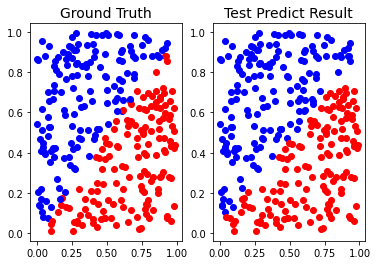

In [1157]:
INPUT_SIZE = 2
OUTPUT_SIZE = 1
HIDDEN_UNITS = ((3, False), (3, False))

EPOCH_SIZE = 2000
EARLY_STOPPING = True

# Model
model_random_generator: np.random.Generator = np.random.default_rng(seed = 4321)
optimizer = Momentum(learning_rate=1e-5, momentum=0.9)
# optimizer = SGD(learning_rate=3e-4)
network = UniformNetwork(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_UNITS, model_random_generator, bias=False)

# Data
x_train, x_val, x_test, y_train, y_val, y_test = get_uniform_data()

trainer = Trainer(network, optimizer, EPOCH_SIZE, EARLY_STOPPING)
loss_trains, loss_vals, accuracy_trains, accuracy_vals = trainer.train(x_train, x_val, y_train, y_val)

show_loss(loss_trains, loss_vals)
show_accuracy(accuracy_trains, accuracy_vals)
trainer.test(x_test, y_test)

### X like

In [1158]:
def get_X_data():
    points, labels = Data.generate_X_like_data()
    x_train, x_val, x_test, y_train, y_val, y_test = points, points, points, labels, labels, labels

    print("shape of train data:", x_train.shape)
    print("shape of validation data:", x_val.shape)
    print("shape of test data:", x_test.shape)

    print("number of 1 in train data:", np.sum(y_train == 1))
    print("number of 0 in train data:", np.sum(y_train == 0))
    print("number of 1 in validation data:", np.sum(y_val == 1))
    print("number of 0 in validation data:", np.sum(y_val == 0))

    return x_train, x_val, x_test, y_train, y_val, y_test

shape of train data: (21, 2)
shape of validation data: (21, 2)
shape of test data: (21, 2)
number of 1 in train data: 10
number of 0 in train data: 11
number of 1 in validation data: 10
number of 0 in validation data: 11
epoch: 1000, train loss: 0.6926204538483832, validation loss: 0.6926201612037535
epoch: 2000, train loss: 0.6923998180691099, validation loss: 0.6923996572435569
epoch: 3000, train loss: 0.6922871529578973, validation loss: 0.6922871380765182
epoch: 4000, train loss: 0.6922743624970658, validation loss: 0.6922743641144317
epoch: 5000, train loss: 0.6922285515944048, validation loss: 0.692228531813946
epoch: 6000, train loss: 0.6922274297356628, validation loss: 0.692227443506452
epoch: 7000, train loss: 0.6922503927458129, validation loss: 0.6922504228375785
epoch: 8000, train loss: 0.6922845112627879, validation loss: 0.6922845482937292
epoch: 9000, train loss: 0.6923186292784683, validation loss: 0.6923186648738829
epoch: 10000, train loss: 0.6923547103205733, valida

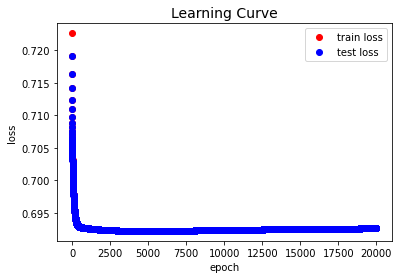

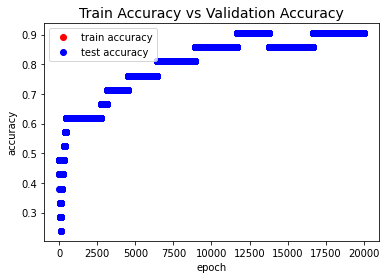

Test Predict Result:
[[0.49960202]
 [0.50037391]
 [0.49995908]
 [0.50020624]
 [0.49991559]
 [0.50003857]
 [0.49987209]
 [0.49987091]
 [0.4998286 ]
 [0.49964628]
 [0.49978511]
 [0.49974162]
 [0.50003611]
 [0.49969812]
 [0.50028712]
 [0.49965463]
 [0.50053812]
 [0.49961114]
 [0.50078912]
 [0.49956764]
 [0.50104013]]
Test Predict Accuracy: 0.9047619047619048


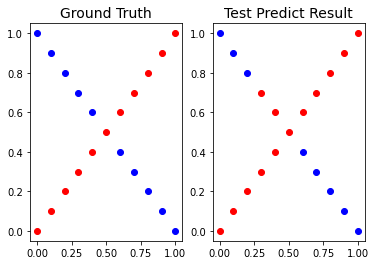

In [1159]:
INPUT_SIZE = 2
OUTPUT_SIZE = 1
HIDDEN_UNITS = ((4, True, 0.2), (5, True, 0.3))

EPOCH_SIZE = 20000
EARLY_STOPPING = False

# Model
model_random_generator: np.random.Generator = np.random.default_rng(seed = 4321)
optimizer = SGD(learning_rate=1e-1)
network = XORNetwork(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_UNITS, model_random_generator, bias = True)

# Data
x_train, x_val, x_test, y_train, y_val, y_test = get_X_data()

trainer = Trainer(network, optimizer, EPOCH_SIZE, EARLY_STOPPING)
loss_trains, loss_vals, accuracy_trains, accuracy_vals = trainer.train(x_train, x_val, y_train, y_val)

show_loss(loss_trains, loss_vals)
show_accuracy(accuracy_trains, accuracy_vals)
trainer.test(x_test, y_test)